In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm


from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from hurst import compute_Hc
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from itertools import combinations
from sklearn.decomposition import PCA
from arch.unitroot import engle_granger
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

from warnings import filterwarnings

filterwarnings('ignore')


In [96]:
class pair_select:

    def __init__ (self, price_df, etf_info, formation_start_date, formation_end_date, trade_start_date, trade_end_date):
        self.price_df               = price_df                  # Price History
        self.etf_info               = etf_info                  # etf_info
        self.formation_start_date   = formation_start_date      
        self.formation_end_date     = formation_end_date        
        self.trade_start_date       = trade_start_date           
        self.trade_end_date         = trade_end_date        
    
        _, self.close_df_test, self.rtn_df_test, self.low_volume_etf_test \
            = self.preprocessing(self.trade_start_date, self.trade_end_date)

        self.preprocessing(self.formation_start_date, self.formation_end_date)
        self.get_clustering()
        self.get_pair_selection()

    def preprocessing (self, start_date, end_date):
        '''For formation, input formation period'''
        
        formation = self.price_df[(self.price_df.Date >= start_date) & (self.price_df.Date < end_date)].set_index('Date')
        #formation_etf_list = list(formation[formation.index == formation.index[0]].tic.unique())
        formation_etf_list = list(formation[formation.index == formation.index[0]].tic.unique())
        
        close_df = pd.DataFrame(index = formation.index.unique())

        for x in tqdm(formation_etf_list):
            tmp = formation['Close'][formation.tic == x]
            close_df = pd.concat([close_df, tmp], axis=1)

        close_df.columns = formation_etf_list
        #rtn_df = close_df.pct_change()[1:] # return을 pct로?
        rtn_df = np.log(close_df).diff()[1:]

        etf_info['volume'] = etf_info['Avg. Daily Volume'].str.replace(',','').astype('float')
        low_volume_etf = etf_info[etf_info.volume < etf_info.volume.quantile(0.1)].Symbol.to_list()

        self.formation       = formation
        self.close_df        = close_df
        self.rtn_df          = rtn_df
        self.low_volume_etf  = low_volume_etf

        return formation, close_df, rtn_df, low_volume_etf

    def get_pca_return(self, pc_selecting_threshold=0.9):

        rtn_df_scaled = pd.DataFrame(StandardScaler().fit_transform(self.rtn_df))
        pca = PCA()
        pca.fit(rtn_df_scaled)
        cumsum_eigen_value = np.cumsum(pca.explained_variance_ratio_)
        pca_components = pca.components_[:np.where(cumsum_eigen_value >= pc_selecting_threshold)[0][0]]

        pc_rtn = pd.DataFrame(data=pca_components.T, index=self.rtn_df.columns)
        pc_rtn = pc_rtn.add_prefix("P")

        self.pc_rtn = pc_rtn

        return pc_rtn        

    def get_clustering(self, pca_rtn=None, eps=1.8, min_samples=4, cluster_size_limit=100, cluster_member_counts=100):

        if pca_rtn is not None:
            pc_rtn = pca_rtn
        else:
            pc_rtn = self.get_pca_return()        

        data = StandardScaler().fit_transform(pc_rtn)
        clf = DBSCAN(eps=eps, min_samples=min_samples)
        clf.fit(data)

        labels = clf.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print("Clusters discovered: %d" % n_clusters_)

        clustered = clf.labels_
        clustered_series = pd.Series(index = pc_rtn.index, data = clustered.flatten())
        clustered_series_all = pd.Series(index = pc_rtn.index, data = clustered.flatten())
        clustered_series = clustered_series[clustered_series != -1]

        counts = clustered_series.value_counts()
        ticker_count_reduced = counts[(counts > 1) & (counts <= cluster_size_limit)]
        print("Clusters formed: %d" % len(ticker_count_reduced))
        print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())


        # 클러스터링 안에 etf가 너무 많으면 pair selection 시간 너무 많이 걸림. 너무 많은 etf 포함하고 있는 clustering 제외하기
        # cluster_memeber_counts 파라미터 조정 필요. 너무 크면 돌리는데 시간이 오래 걸리고, 너무 작으면 페어가 안뽑힐 수도 있음. 
        counts = clustered_series.value_counts()
        clusters_viz_list = list(counts[(counts < cluster_member_counts) & (counts > 1)].index)[::-1]
        print('final_clusters index : ', clusters_viz_list)

        self.clusters_viz_list = clusters_viz_list
        self.clustered_series  = clustered_series

        return clusters_viz_list, clustered_series

    def get_pair_selection(self, inverse_threshold=0.99,\
                                 coint_pvalue_threshold=0.05,\
                                 hurst_threshold=0.5,\
                                 half_life_threshold=30,\
                                 mean_reverting_freq=12):

        '''pair with list, short_pair with dict'''
        selected_pair = []
        for i in tqdm(range(len(self.clusters_viz_list))):
            test_list = list(self.clustered_series[self.clustered_series == self.clusters_viz_list[i]].index)

            # 1. 거래량 10분위 이하 제거
            vol_screened_test_list = []
            for x in test_list:
                if (x in self.low_volume_etf) == False:
                    vol_screened_test_list.append(x)       
                    
            # 2. corr -0.99 보다 작은 etf가 존재하는지 -> 숏포지션 잡을 수 있는지 여부
            short_avail_test_list = []
            short_pair = {}
            for x in vol_screened_test_list:
                if self.rtn_df.corr()[x].min() < inverse_threshold:
                    short_avail_test_list.append(x)
                    short_pair[x] = self.rtn_df.corr()[x].idxmin()
                    
            # 3. Cointegration - pvalue 0.05 이하인 pair sorting
            log_price_data = np.log(self.close_df[short_avail_test_list])
            comb = list(combinations(short_avail_test_list, 2))
            eg_pvalue = {}

            for x in tqdm(comb):
                score, pvalue, _ = coint(log_price_data[x[0]], log_price_data[x[1]], method='aeg')
                eg_pvalue[x] = pvalue

            possible_pair = [x[0] for x in sorted(eg_pvalue.items(), key=lambda item: item[1]) if x[1] <= coint_pvalue_threshold]

            # 4. Hurst exponent test - mean reverting intensity : H < 0.5 이하인 종목 선정
            spread_df = pd.DataFrame(index = log_price_data.index)

            for x in possible_pair:
                spread_df[x] = self.close_df[x[0]] - self.close_df[x[1]]
            
            hurst_screened_list = []

            for cnd in possible_pair:
                if compute_Hc(spread_df[cnd])[0] <= hurst_threshold:
                    hurst_screened_list.append(cnd)

            spread_df = spread_df[hurst_screened_list]

            # 5. Half life가 trading period 안에 들어오는 종목 스크리닝
            spread_df_lag = spread_df.shift(1)
            spread_df_diff = spread_df - spread_df_lag

            hl_screened_list = []

            for i in range(len(hurst_screened_list)):

                X = sm.add_constant(spread_df_lag.iloc[1:,i])
                model = sm.OLS(spread_df_diff.iloc[1:,i], X)
                result = model.fit()
                lamda = result.params[1]
                HL = -np.log(2) / lamda

            # trading period 고려
                if (HL <= half_life_threshold) & (HL >= 1):
                    hl_screened_list.append(hurst_screened_list[i])

            spread_df = spread_df[hl_screened_list]

            # 6. mean-reverting freq이 충분히 자주 발생하는지 스크리닝
            freq_screened_list = []

            for j in range(len(spread_df.columns)):

                cnt = 0

                for i in range(len(spread_df.index)):

                    if i == len(spread_df.index) -1:
                        break

                    elif spread_df.iloc[i+1,j] >= spread_df.iloc[i,j]:
                        if (spread_df.mean()[j] >= spread_df.iloc[i,j]) & (spread_df.mean()[j] <= spread_df.iloc[i+1,j]):
                            cnt += 1

                    else:
                        if (spread_df.mean()[j] >= spread_df.iloc[i+1,j]) & (spread_df.mean()[j] <= spread_df.iloc[i,j]):
                            cnt += 1
                
                if cnt >= mean_reverting_freq:
                    freq_screened_list.append(hl_screened_list[j])

            selected_pair.append(freq_screened_list)

        self.selected_pair = selected_pair
        self.short_pair = short_pair

        return selected_pair, short_pair

    #def 


In [97]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'])
etf_info = pd.read_csv('./Data/etfs_details_equity.csv')

start_date       = '2020-01-01'
end_date         = '2020-12-31'
test_start_date  = '2021-01-01'
test_end_date    = '2021-12-31'

ps = pair_select(price_df, etf_info, start_date, end_date, test_start_date, test_end_date)

100%|██████████| 1338/1338 [00:21<00:00, 62.37it/s]


Clusters discovered: 6
Clusters formed: 5
Pairs to evaluate: 1694
final_clusters index :  [5, 4, 3, 1, 2]


100%|██████████| 5/5 [01:43<00:00, 20.63s/it]


In [102]:
ps.selected_pair[4][0]

('SKF', 'EMTY')

200

In [117]:
pair = ps.selected_pair[4][0]
pair_1 = pair[0]
pair_2 = pair[1]

#pair_1, pair_2

close_df = ps.close_df[[pair_1, pair_2]]
rtn_df = ps.rtn_df[[pair_1, pair_2]]
close_df_test = ps.close_df_test[[pair_1, pair_2]]
rtn_df_test = ps.rtn_df_test[[pair_1, pair_2]]


Found기간 동안, 페어에서 베타 알파 뽑기

In [153]:

import statsmodels.api as sm

X = np.log(close_df[pair_1])
X_const = sm.add_constant(np.log(close_df[pair_1]))
Y = np.log(close_df[pair_2])

model = sm.OLS(endog=Y, exog=X_const).fit()
beta = model.params[1]
alpha = model.params[0]

pred = np.log(close_df[pair_1]) * beta + alpha


OLS를 활용해서 그래프 뽑기

Text(0, 0.5, 'EMTY')

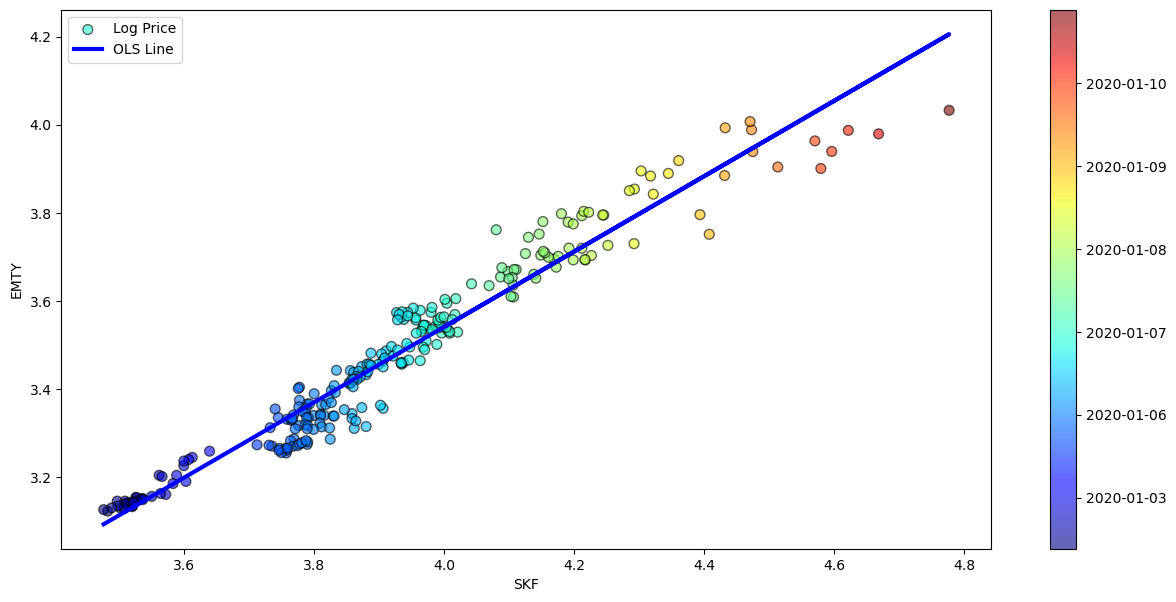

In [198]:
plt.figure(figsize=(15,7))
cm = plt.get_cmap('jet')
sc = plt.scatter(np.log(close_df[pair_1]), np.log(close_df[pair_2]), s=50, cmap=cm, c=X, marker='o', alpha=0.6,label='Log Price',edgecolor='k')
plt.plot(X, pred, '-', c='blue', linewidth=3, label='OLS Line')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p)[0:10] for p in close_df.index])
plt.xlabel(pair_1)
plt.ylabel(pair_2)

foundation 기간 가격 스프레드

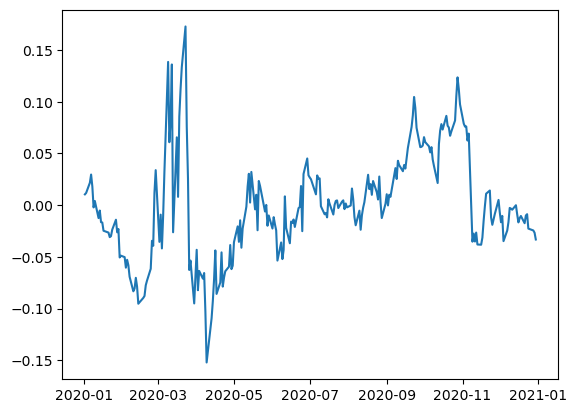

In [199]:
ols_spread = np.log(close_df[pair_1]) * beta + alpha - np.log(close_df[pair_2])
plt.plot(ols_spread)

foundation 기간의 ADF테스트로 정상성 검정

In [200]:
adf = sm.tsa.stattools.adfuller(ols_spread, maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf[1])

ADF test statistic: -3.20
	1%: -3.457
	5%: -2.873
	10%: -2.573
p-value: 0.020


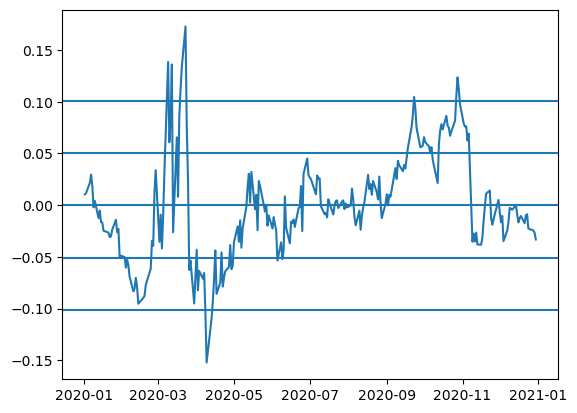

In [209]:
mean = ols_spread.mean()
upper = mean + 2 * ols_spread.std()
lower = mean - 2 * ols_spread.std()
open = mean + 1 * ols_spread.std()
end = mean - 1 * ols_spread.std()

plt.plot(ols_spread)
plt.axhline(upper)
plt.axhline(lower)
plt.axhline(open)
plt.axhline(end)
plt.axhline(mean)


In [210]:
open_position = np.where(ols_spread > open, 1, 0)
close_position = np.where(ols_spread )

In [ ]:
df['buy'] = df['spread'][((df['spread'] < df['lower']) & (df['spread'].shift(1) > df['lower']) | 
                          (df['spread'] <  df['mean']) & (df['spread'].shift(1) >  df['mean']))]

df['sell'] = df['spread'][((df['spread'] > df['upper']) & (df['spread'].shift(1) < df['upper']) | 
                           (df['spread'] >  df['mean']) & (df['spread'].shift(1) <  df['mean']))]
df.plot(figsize =(17,10), style=['g', '--r', '--b', '--b', 'm^','cv'])

test 기간에서의 ols spread 생성

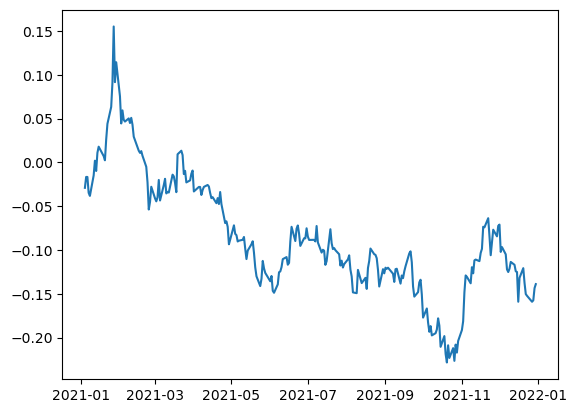

ADF test statistic: -1.72
	1%: -3.457
	5%: -2.873
	10%: -2.573
p-value: 0.421


In [190]:
ols_spread_test = np.log(close_df_test[pair_1]) * beta + alpha - np.log(close_df_test[pair_2])
plt.plot(ols_spread_test)
plt.show()

adf = sm.tsa.stattools.adfuller(ols_spread_test, maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf[1])